# 1차 모델 구축

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# SMOTE + 파이프라인 (imblearn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [82]:
# 0. 데이터 불러오기
df = pd.read_csv("stroke.csv")

In [83]:
# 4-0 숫자형 변수 목록
num_cols = ["age", "avg_glucose_level", "bmi"]

# 4-0 범주형 변수 목록
cat_cols = ["gender", "hypertension", "heart_disease", 
            "ever_married", "work_type", "Residence_type", 
            "smoking_status"]

In [66]:
# 성인(adult) 그룹만 사용 (age >= 18)
adult_df = df[df["age"] >= 18].copy()

# 타깃 변수
target = "stroke"

# id 컬럼이 있으면 제거 (모델 학습에 필요 없음)
drop_cols = [target]
if "id" in adult_df.columns:
    drop_cols.append("id")

X = adult_df.drop(columns=drop_cols)
y = adult_df[target]

# 전처리 파이프라인
# - 숫자형: RobustScaler (이상치에 덜 민감)
# - 범주형: One-Hot 인코딩
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 나누기 (성인 그룹 안에서만)-
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # 불균형 클래스 비율 유지
    random_state=42
)

In [67]:
# Logistic Regression
logistic_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",   # 불균형 보정
            solver="lbfgs"
        ))
    ]
)

logistic_clf.fit(X_train, y_train)

y_pred_lr = logistic_clf.predict(X_test)
y_proba_lr = logistic_clf.predict_proba(X_test)[:, 1]

print("✅ Logistic Regression 성능 (성인 그룹)")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("-" * 60)

✅ Logistic Regression 성능 (성인 그룹)
              precision    recall  f1-score   support

           0      0.977     0.737     0.840       802
           1      0.142     0.714     0.237        49

    accuracy                          0.736       851
   macro avg      0.560     0.726     0.539       851
weighted avg      0.929     0.736     0.805       851

ROC-AUC: 0.8006768792304952
------------------------------------------------------------


# 결과
- AUC = 0.801
- stroke 1 recall = 0.714
- Precicion = 0.142

# 해석
- 뇌졸중을 71% 잡아내지만, 잡은 것중 14%가 진짜임.

# 1차 ROC 곡선

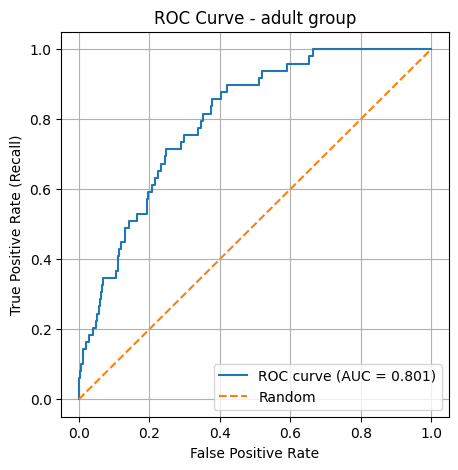

In [69]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - adult group")
plt.legend()
plt.grid(True)
plt.show()

# 1차 threshold recall = 0.80

In [70]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (성인 그룹)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold (성인 그룹)
- threshold ≈ 0.383
- recall(=TPR) ≈ 0.796
- FPR ≈ 0.345

✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹)
- precision_1 = 0.123
- recall_1    = 0.796
- f1_1        = 0.214


# 1차 threshold recall = 0.90

In [71]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (성인 그룹)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold (성인 그룹)
- threshold ≈ 0.309
- recall(=TPR) ≈ 0.898
- FPR ≈ 0.421

✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹)
- precision_1 = 0.115
- recall_1    = 0.898
- f1_1        = 0.204


# 결과 해석
- 의심 환자를 넓게 잡아서 90% 잡을 수는 있음
- 하지만 FPR이 거의 절반 수준

⚠️ 의심 대상 선별 수준

# 2차 모델 구축
## SMOTE 적용

In [76]:
# 성인(adult) 그룹만 사용 (age >= 18)
adult_df = df[df["age"] >= 18].copy()

target = "stroke"

# id 컬럼이 있으면 제거 (모델 학습에 필요 없는 식별자)
drop_cols = [target]
if "id" in adult_df.columns:
    drop_cols.append("id")

X = adult_df.drop(columns=drop_cols)
y = adult_df[target]

# 전처리 파이프라인
# - 숫자형: RobustScaler (이상치에 덜 민감)
# - 범주형: One-Hot 인코딩

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 나누기 (성인 그룹 안에서만)
# - SMOTE는 반드시 train에만 적용해야 하므로
#   split을 먼저 해주고, 파이프라인 안에서 train에만 적용되게 함
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # 불균형 비율 유지
    random_state=42
)

# SMOTE 설정 (소수 클래스 = stroke=1 을 synthetic하게 늘려주는 역할)
smote = SMOTE(random_state=42)

In [77]:
# Logistic Regression + SMOTE 파이프라인
logistic_clf = ImbPipeline(
    steps=[
        ("preprocess", preprocess),   # 1) 전처리 (스케일링 + 원핫)
        ("smote", smote),             # 2) train 데이터에만 SMOTE oversampling
        ("model", LogisticRegression(
            max_iter=1000,
            # SMOTE로 이미 클래스 밸런스를 맞춰주므로
            # class_weight는 일단 사용하지 않아도 됨 (원하면 'balanced'로 테스트 가능)
            solver="lbfgs"
        ))
    ]
)

logistic_clf.fit(X_train, y_train)

y_pred_lr = logistic_clf.predict(X_test)
y_proba_lr = logistic_clf.predict_proba(X_test)[:, 1]

print("✅ Logistic Regression + SMOTE 성능 (성인 그룹 + SMOTE 적용)")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("-" * 60)

✅ Logistic Regression + SMOTE 성능 (성인 그룹 + SMOTE 적용)
              precision    recall  f1-score   support

           0      0.970     0.738     0.839       802
           1      0.129     0.633     0.214        49

    accuracy                          0.732       851
   macro avg      0.550     0.685     0.526       851
weighted avg      0.922     0.732     0.803       851

ROC-AUC: 0.7837294518805028
------------------------------------------------------------


/home/kdt_43/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# 결과 해석
- SMOTE로 minority를 늘리면 dicision boundary가 틀어짐
    - Logistic Regression은 오히려 AUC가 떨어지는 경우가 많음
        - XGBoost에서 적용해 보는 건 어떨까?

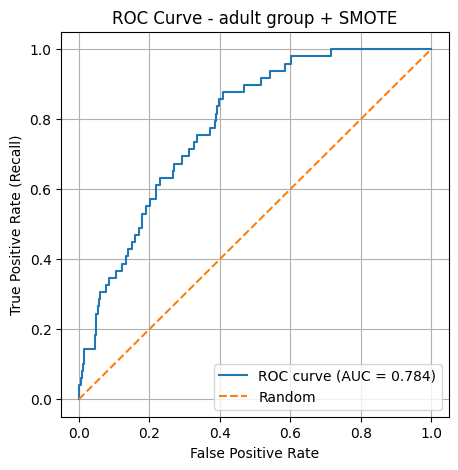

In [79]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - adult group + SMOTE")
plt.legend()
plt.grid(True)
plt.show()

# 2차 threshold_recall = 0.80

In [80]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (성인 그룹 + SMOTE 적용)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹 + SMOTE 적용)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold (성인 그룹 + SMOTE 적용)
- threshold ≈ 0.331
- recall(=TPR) ≈ 0.796
- FPR ≈ 0.385

✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹 + SMOTE 적용)
- precision_1 = 0.112
- recall_1    = 0.796
- f1_1        = 0.196


# 2차 threshold_recall = 0.90

In [81]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (성인 그룹 + SMOTE 적용)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹 + SMOTE 적용)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold (성인 그룹 + SMOTE 적용)
- threshold ≈ 0.234
- recall(=TPR) ≈ 0.898
- FPR ≈ 0.468

✅ 선택한 threshold에서 stroke=1 성능 (성인 그룹 + SMOTE 적용)
- precision_1 = 0.105
- recall_1    = 0.898
- f1_1        = 0.188


# 결과 해석
- 전보다 Precision은 떨어짐
- Recall은 동일하게 달성 가능
- FPR 높아짐
    - SMOTE는 Recall 개선에는 도움을 거의 주지 않고 있음
    - Precicion과 AUC는 오히려 약화
    - XGBoost를 써보는게 어떨까?

# 3차 모델 구축
## 전체 데이터 사용

In [84]:
target = "stroke"

drop_cols = [target]
if "id" in df.columns:   # id 컬럼 있으면 제거
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df[target]

# 숫자형 / 범주형 컬럼 구분
num_cols = ["age", "avg_glucose_level", "bmi"]    # 연속형 변수
# 나머지는 모두 범주형 취급 (0/1 포함)
cat_cols = ["gender", "hypertension", "heart_disease", 
            "ever_married", "work_type", "Residence_type", 
            "smoking_status"]

# 전처리 파이프라인
# - 숫자형: RobustScaler
# - 범주형: One-Hot 인코딩
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # stroke 비율 유지
    random_state=42
)

# SMOTE 설정 (소수 클래스 = stroke=1 증가)
smote = SMOTE(random_state=42)

In [85]:
# Logistic Regression + SMOTE (전체 데이터)
logistic_clf = ImbPipeline(
    steps=[
        ("preprocess", preprocess),   # 1) 스케일링 + 원핫
        ("smote", smote),             # 2) train 데이터에만 SMOTE 적용
        ("model", LogisticRegression(
            max_iter=1000,
            solver="lbfgs"
        ))
    ]
)

logistic_clf.fit(X_train, y_train)

y_pred_lr = logistic_clf.predict(X_test)
y_proba_lr = logistic_clf.predict_proba(X_test)[:, 1]

print("✅ Logistic Regression + SMOTE 성능 (전체 데이터)")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("-" * 60)

✅ Logistic Regression + SMOTE 성능 (전체 데이터)
              precision    recall  f1-score   support

           0      0.986     0.748     0.851       972
           1      0.140     0.800     0.239        50

    accuracy                          0.750      1022
   macro avg      0.563     0.774     0.545      1022
weighted avg      0.945     0.750     0.821      1022

ROC-AUC: 0.843477366255144
------------------------------------------------------------


/home/kdt_43/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


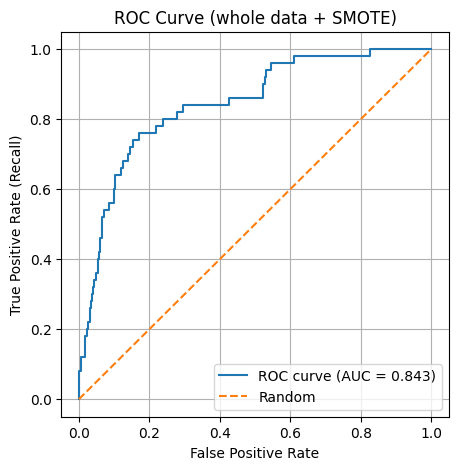

In [88]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (whole data + SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

# 3차 threshold_recall = 0.80

In [89]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (전체 데이터 + SMOTE)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (전체 데이터 + SMOTE)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold (전체 데이터 + SMOTE)
- threshold ≈ 0.529
- recall(=TPR) ≈ 0.800
- FPR ≈ 0.238

✅ 선택한 threshold에서 stroke=1 성능 (전체 데이터 + SMOTE)
- precision_1 = 0.148
- recall_1    = 0.800
- f1_1        = 0.249


# 3차 threshold_recall = 0.90

In [90]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold (전체 데이터 + SMOTE)")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_lr >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능 (전체 데이터 + SMOTE)")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold (전체 데이터 + SMOTE)
- threshold ≈ 0.135
- recall(=TPR) ≈ 0.900
- FPR ≈ 0.524

✅ 선택한 threshold에서 stroke=1 성능 (전체 데이터 + SMOTE)
- precision_1 = 0.081
- recall_1    = 0.900
- f1_1        = 0.149


# 결과 해석
- 그룹으로 나눈 것보다 Recall이 더 좋아짐
- AUC도 가장 높음

# 추가로 고려해야 할 것들
- 다른 모델을 써보자
    - XGBoost
    - LightGBM
    - CatBoost
